In [285]:
import numpy as np
import pandas as pd
import yaml
import torch
from torch import nn
import scanpy as sc

from torch.utils.data import DataLoader
import pytorch_lightning as pl

import torch.nn.functional as F

from scvi.distributions import NegativeBinomial
from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.vdm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.vdm.vdm import VDM
from celldreamer.eval.optimal_transport import wasserstein

from celldreamer.models.base.utils import unsqueeze_right
import matplotlib.pyplot as plt

device  = "cuda" if torch.cuda.is_available() else "cpu"

**Util function**

**Cofigurations**

In [286]:
dataset_config = {'dataset_path': '/home/icb/alessandro.palma/environment/celldreamer/datasets/processed/pbmc68k.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['celltype'],
                    'sampling_covariate': 'celltype',
                    'subsample_frac': 1,
                    'encoder_type': 'log_gexp',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': True,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': None}

In [287]:
# ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/celldreamer/02ed0f92-c9b1-44a1-ada8-4f3fdc2f3594/checkpoints/last.ckpt")

In [288]:
# ckpt["state_dict"]["theta"].max()

**Initialization**

Initialize dataset 

In [289]:
data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Initialize feature embeddings

In [291]:
class Encoder(pl.LightningModule):
    def __init__(self, lr, l2_weight=1e-5):
        super().__init__()  
        self.lr = lr
        self.l2_weight = l2_weight  # Weight for the L2 loss term

        self.theta_preexp = nn.Parameter(torch.randn(2000), requires_grad=True)
        self.encoder = nn.Sequential(
            nn.Linear(2000, 1000),
            nn.BatchNorm1d(1000),
            nn.SELU(),
            nn.Linear(1000, 512))
        
        self.decoder = nn.Sequential(
            nn.Linear(512, 1000),
            nn.BatchNorm1d(1000),
            nn.SELU(),
            nn.Linear(1000, 2000))

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        theta = torch.exp(self.theta_preexp)
        return x_hat, theta, z
    
    def training_step(self, batch, batch_idx):
        X = batch['X']
        l = X.sum(1).unsqueeze(1)
        y = batch["y"]
        X_log = torch.log1p(X)

        roh_presoftmax, theta, z = self.forward(X_log)
        roh = F.softmax(roh_presoftmax, dim=1)

        px = NegativeBinomial(mu=l*roh, theta=theta)
        reconstruction_loss = - px.log_prob(X).sum(1).mean()

        # L2 loss term on the latent space
        l2_loss = torch.norm(z, p=2)  # Adjust the weight as needed

        # Total loss
        loss = reconstruction_loss + self.l2_weight * l2_loss

        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('reconstruction_loss', reconstruction_loss, on_epoch=True, prog_bar=True)
        self.log('l2_loss', l2_loss, on_epoch=True, prog_bar=True)
        return loss 

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), weight_decay=0.01, lr=self.lr)

# Instantiate the Encoder model
encoder_model = Encoder(lr=0.001).cuda()

dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Instantiate a Lightning Trainer
trainer = pl.Trainer(max_epochs=100)  # You can adjust max_epochs and gpus as needed

# Train the model
trainer.fit(encoder_model, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder      | Sequential | 2.5 M 
1 | decoder      | Sequential | 2.5 M 
  | other params | n/a        | 2.0 K 
--------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
20.138    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [292]:
encoder_model.to("cuda")

Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=2000, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
    (3): Linear(in_features=1000, out_features=512, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
    (3): Linear(in_features=1000, out_features=2000, bias=True)
  )
)

In [295]:
Z_enc = []
X_real = []
X_generated = []

with torch.no_grad():
    for batch in dataloader:
        # Logarithm of X
        l = batch["X"].sum(1).unsqueeze(1).cuda()
        y = batch["y"]["y_celltype"]
        # X_log = dataset.scaler.scale(batch["X_norm"].cuda())
        X_log = torch.log1p(batch["X"].cuda())
        Z = encoder_model.encoder(X_log)
        Z_enc.append(Z.cpu())
        X_real.append(batch["X"].cpu())
        # Sample 
        distr = NegativeBinomial(mu=torch.softmax(encoder_model.decoder(Z), 1)*l, theta=torch.exp(encoder_model.theta_preexp))
        X_sample = distr.sample()
        X_generated.append(X_sample.cpu())

Z_enc = torch.cat(Z_enc, dim=0)
X_real = torch.cat(X_real, dim=0)
X_generated = torch.cat(X_generated, dim=0)

In [296]:
Z_enc.min()

tensor(-2.8956)

In [297]:
adata_z = sc.AnnData(X=Z_enc.numpy())
obs = pd.DataFrame(["real" for _ in range(len(X_real))]+["generated" for _ in range(len(X_generated))])
obs.columns = ["dataset_type"]
adata = sc.AnnData(torch.cat([X_real, X_generated], dim=0).numpy(),
                  obs=obs)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [298]:
for batch in dataloader:
    scaled = dataset.scaler.scale(batch["X_norm"].cuda())
    # scaled = batch["X_norm"]
    break

**Check embeddings**

In [299]:
sc.tl.pca(adata_z)
sc.pp.neighbors(adata_z)
sc.tl.umap(adata_z)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


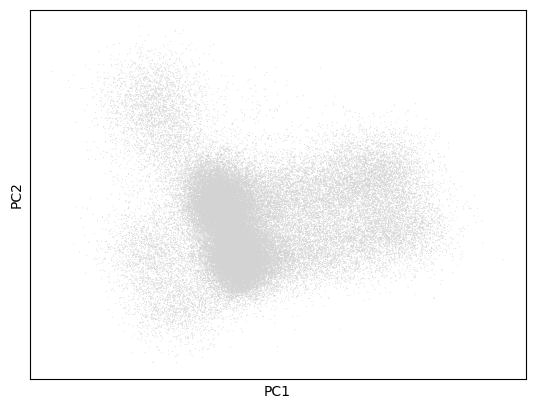

In [300]:
sc.pl.pca(adata_z)

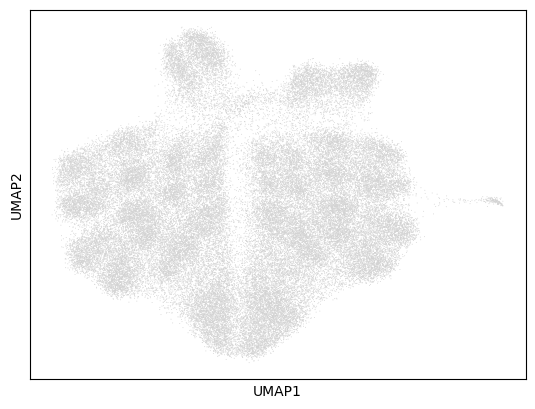

In [301]:
sc.pl.umap(adata_z)

**Real versus generated**

In [303]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


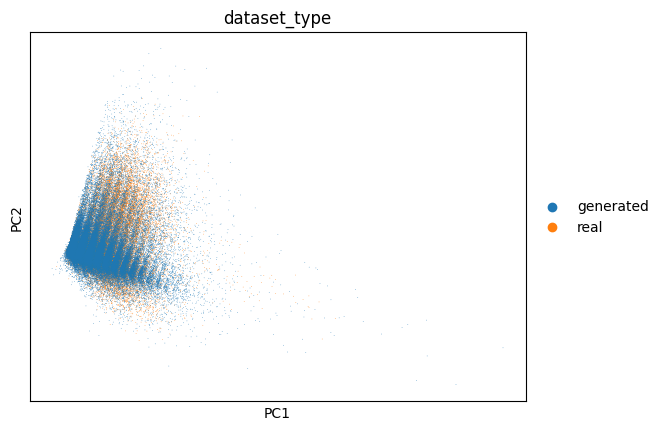

In [304]:
sc.pl.pca(adata, color="dataset_type")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


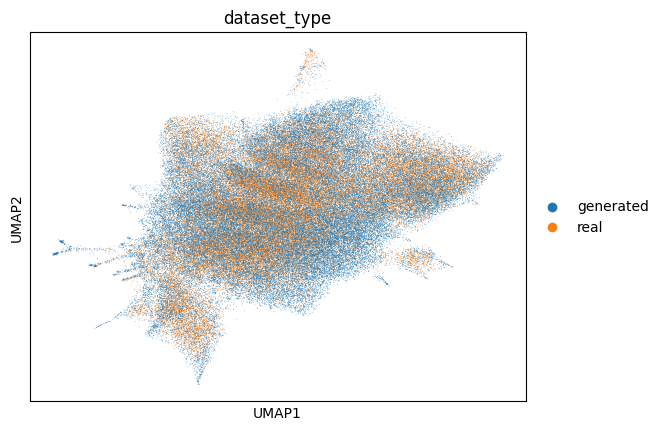

In [305]:
sc.pl.umap(adata, color="dataset_type")

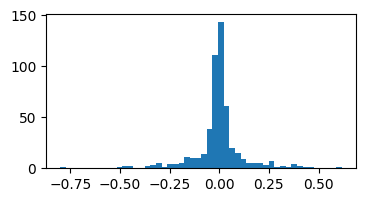

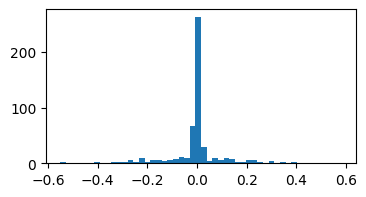

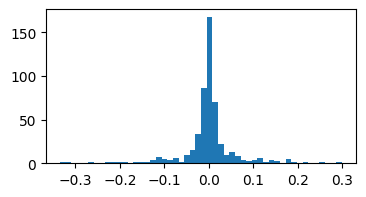

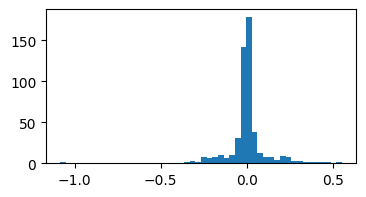

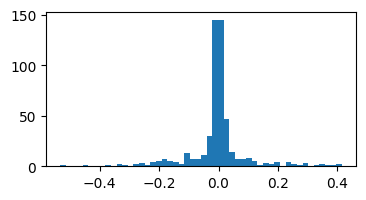

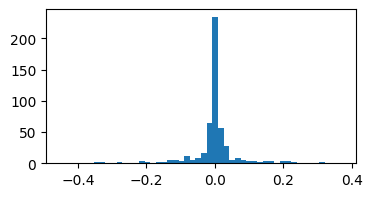

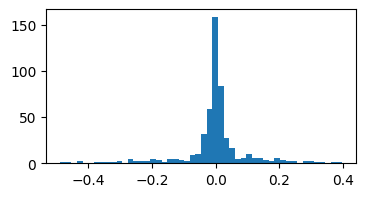

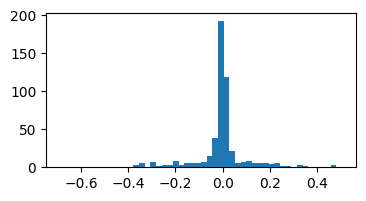

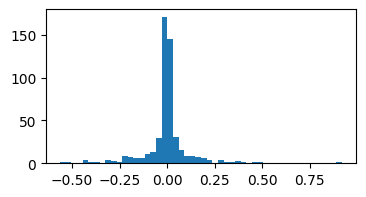

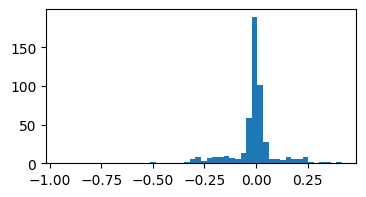

In [309]:
for i in range(10):
    plt.figure(figsize=(4,2))
    plt.hist(Z_enc[i].ravel(), 50)
    plt.show()

In [307]:
Z_enc[0]

tensor([-7.9151e-02, -7.4514e-03,  9.8528e-03,  8.1549e-02,  1.1665e-02,
        -3.4177e-03,  4.4253e-02,  4.4958e-02, -3.8459e-02,  4.6482e-02,
        -1.0334e-02, -9.6024e-02, -1.3449e-02,  6.0931e-03, -1.5433e-03,
        -2.0113e-02,  1.2701e-02, -2.1659e-01, -5.3059e-02,  3.0182e-03,
         1.8957e-02, -3.0601e-01, -3.1913e-01,  8.8947e-03,  2.8850e-02,
         8.1209e-02,  5.7135e-02, -1.6530e-02, -1.8542e-02, -3.6424e-01,
         3.2987e-02, -1.5365e-01,  1.0018e-02,  1.0924e-01,  2.6873e-01,
         3.2224e-03, -1.9386e-02,  4.1053e-02,  1.8929e-02,  4.9040e-03,
        -1.2099e-02,  1.4538e-04, -1.9261e-02,  1.9953e-02,  2.4127e-02,
        -5.0305e-02,  1.7148e-02, -1.6256e-02,  4.1986e-02, -5.3822e-02,
         1.8716e-02,  1.6046e-01,  4.8168e-03,  3.3588e-02, -3.1074e-01,
         1.6532e-02,  1.3490e-02,  3.3080e-02,  3.8260e-02,  1.4657e-02,
        -9.6244e-02,  5.2147e-02, -4.0008e-02, -2.9777e-01,  6.9803e-02,
        -3.3680e-02,  1.9066e-01,  2.1614e-02, -7.5

In [308]:
Z_enc[1]

tensor([-4.7358e-02,  7.9026e-03,  4.2311e-03,  1.7563e-02, -1.3672e-02,
         1.0342e-04, -9.4459e-03,  3.9764e-01,  2.5689e-03,  1.1792e-02,
        -2.1193e-02, -5.8129e-02,  7.9879e-04,  4.6831e-03,  9.8533e-03,
         1.9838e-03, -2.7718e-03,  1.5089e-01, -6.0219e-05,  8.8684e-03,
        -1.5434e-02, -7.1711e-02,  3.9343e-02,  6.2185e-03,  6.1520e-03,
        -1.4337e-02,  4.9907e-03, -3.9003e-03,  1.5944e-02, -6.3730e-02,
         7.7628e-03,  1.8483e-02, -4.5869e-03,  8.2043e-02, -4.3802e-01,
         2.6139e-03, -8.7821e-03, -1.2275e-02,  2.0159e-02,  2.0799e-02,
         7.0277e-03, -6.4358e-02,  1.0118e-02,  1.6270e-03,  1.1509e-02,
         2.1033e-01,  2.5488e-01, -8.0325e-03,  7.9803e-03,  6.5169e-03,
         7.9602e-03,  1.0866e-01,  1.8677e-03, -4.0551e-01, -6.0423e-02,
         8.3768e-04,  5.1022e-03,  9.1731e-03,  3.6216e-05,  1.1343e-02,
         4.3217e-02, -6.1352e-03, -1.8814e-04, -5.3151e-01,  3.7932e-01,
        -1.7896e-03, -1.4214e-04, -1.1405e-02,  6.9